/home/ubuntu/anaconda3/envs/imgdesc_tf2/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Generating caption for 1.jpg
Generating caption for bikestunt.jpg
Generating caption for 3.jpg
Generating caption for 4.jpg
Generating caption for surfing.jpeg
Generating caption for 5.jpg


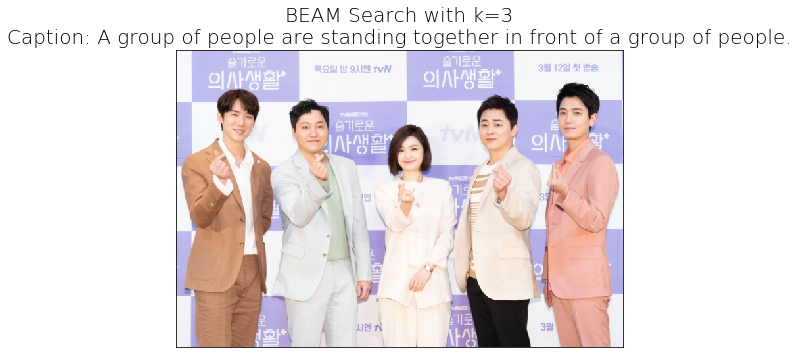

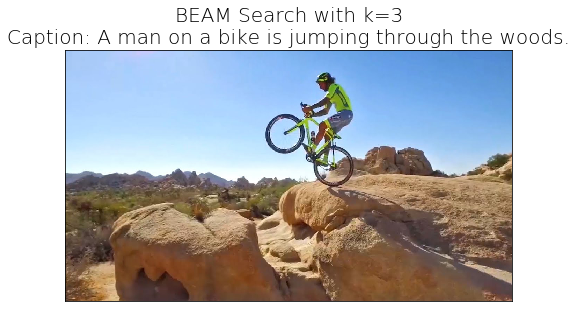

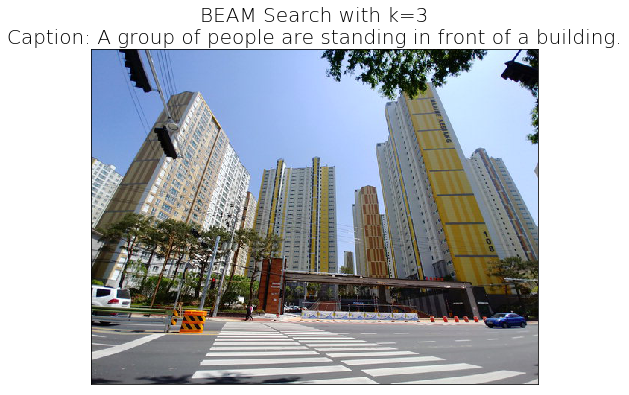

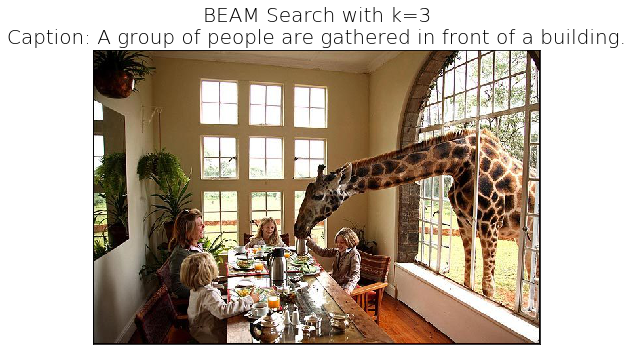

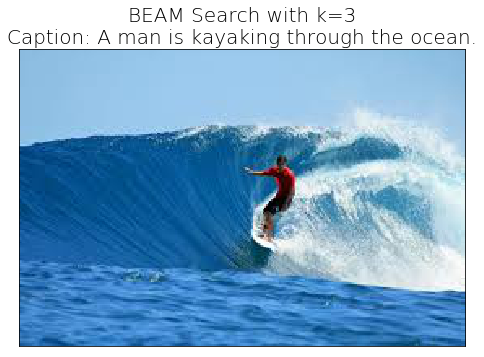

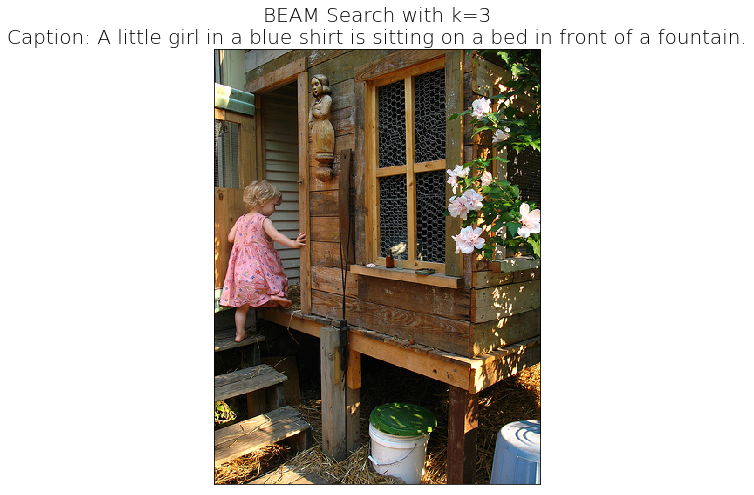

In [4]:
import numpy as np
from PIL import Image
from pickle import load
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from utils.model import CNNModel, generate_caption_beam_search
import os

from config import config

"""
    *Some simple checking
"""
assert type(config['max_length']) is int, 'Please provide an integer value for `max_length` parameter in config.py file'
assert type(config['beam_search_k']) is int, 'Please provide an integer value for `beam_search_k` parameter in config.py file'

# Extract features from each image in the directory
def extract_features(filename, model, model_type):
	if model_type == 'inceptionv3':
		from keras.applications.inception_v3 import preprocess_input
		target_size = (299, 299)
	elif model_type == 'vgg16':
		from keras.applications.vgg16 import preprocess_input
		target_size = (224, 224)
	# Loading and resizing image
	image = load_img(filename, target_size=target_size)
	# Convert the image pixels to a numpy array
	image = img_to_array(image)
	# Reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# Prepare the image for the CNN Model model
	image = preprocess_input(image)
	# Pass image into model to get encoded features
	features = model.predict(image, verbose=0)
	return features

# Load the tokenizer
tokenizer_path = config['tokenizer_path']
tokenizer = load(open(tokenizer_path, 'rb'))

# Max sequence length (from training)
max_length = config['max_length']

# Load the model
caption_model = load_model(config['model_load_path'])

image_model = CNNModel(config['model_type'])

# Load and prepare the image
for image_file in os.listdir(config['test_data_path']):
	if(image_file.split('--')[0]=='output'):
		continue
	if(image_file.split('.')[1]=='jpg' or image_file.split('.')[1]=='jpeg'):
		print('Generating caption for {}'.format(image_file))
		# Encode image using CNN Model
		image = extract_features(config['test_data_path']+image_file, image_model, config['model_type'])
		# Generate caption using Decoder RNN Model + BEAM search
		generated_caption = generate_caption_beam_search(caption_model, tokenizer, image, max_length, beam_index=config['beam_search_k'])
		# Remove startseq and endseq
		caption = 'Caption: ' + generated_caption.split()[1].capitalize()
		for x in generated_caption.split()[2:len(generated_caption.split())-1]:
		    caption = caption + ' ' + x
		caption += '.'
		# Show image and its caption
		pil_im = Image.open(config['test_data_path']+image_file, 'r')
		fig, ax = plt.subplots(figsize=(8, 8))
		ax.get_xaxis().set_visible(False)
		ax.get_yaxis().set_visible(False)
		_ = ax.imshow(np.asarray(pil_im), interpolation='nearest')
		_ = ax.set_title("BEAM Search with k={}\n{}".format(config['beam_search_k'],caption),fontdict={'fontsize': '20','fontweight' : '40'})
		plt.savefig(config['test_data_path']+'output--'+image_file)